<a href="https://colab.research.google.com/github/KarryHarsh/git-set-go/blob/master/defaultersLoanV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna

## Importing libabries

In [ ]:
# Data analysis library
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
%matplotlib inline
# Machine Learning library
import sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric
from sklearn.metrics import f1_score
# Hyperparameter tunning library
import optuna

# Plotting library
import matplotlib.pyplot as plt
# Prevent figures from displaying by turning interactive mode off using the function
plt.ioff()
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'joblib version is {joblib.__version__}')
print(f'optuna version is {optuna.__version__}')

Numpy version is 1.19.5
Pandas version is 1.1.5
sklearn version is 0.22.2.post1
joblib version is 1.0.1
optuna version is 2.6.0


## Introduction to the Data

In [ ]:
## Files
data_file = '/content/drive/MyDrive/Datasets/ML_Artivatic_dataset/train_indessa.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 532428 samples with 45 features.


In [ ]:
# Assigning ID for subbmission
test_data = pd.read_csv("/content/drive/MyDrive/Datasets/ML_Artivatic_dataset/test_indessa.csv")
test_data.head()
ID = test_data["member_id"]

In [ ]:
data = data.replace(' ', np.nan)
test_data = test_data.replace(' ', np.nan)

In [ ]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,NaN,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [ ]:
data['loan_status'].value_counts() # Count of ground truth based on category

0    406601
1    125827
Name: loan_status, dtype: int64

## EDA

In [ ]:
#ratio of null values
data.isnull().sum()/data.shape[0] *100

member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
batch_enrolled                 35.916218
int_rate                        0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.791018
emp_length                      5.050636
home_ownership                  0.000000
annual_inc                      0.000563
verification_status             0.000000
pymnt_plan                      0.000000
desc                           85.801085
purpose                         0.000000
title                           0.016904
zip_code                        0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.003005
inq_last_6mths                  0.003005
mths_since_last_delinq         51.190771
mths_since_last_

In [ ]:
#ratio of null values
test_data.isnull().sum()/test_data.shape[0] *100


member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
batch_enrolled                 48.910131
int_rate                        0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.811788
emp_length                      5.052528
home_ownership                  0.000000
annual_inc                      0.000282
verification_status             0.000000
pymnt_plan                      0.000000
desc                           85.862556
purpose                         0.000000
title                           0.017467
zip_code                        0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.003662
inq_last_6mths                  0.003662
mths_since_last_delinq         51.206505
mths_since_last_

In [ ]:
#len(data.member_id.unique())

In [ ]:
emp_len_dict = {'< 1 year':0,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10}

In [ ]:
data['emp_length'] = data['emp_length'].map(emp_len_dict)
test_data['emp_length'] = test_data['emp_length'].map(emp_len_dict)

In [ ]:
data['Long_emp_length'] = data['emp_length'].apply(lambda x : 'Yes' if x==10 else 'No')
test_data['Long_emp_length'] = test_data['emp_length'].apply(lambda x : 'Yes' if x==10 else 'No')

In [ ]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,505537.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,82123.000000,532412.000000,532412.000000,5.324280e+05,532141.000000,532412.000000,532428.000000,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05,532428.000000
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,6.010559,7.502984e+04,18.138767,0.314448,0.694603,34.055735,70.093068,11.545594,0.194858,1.692128e+04,55.057189,25.267357,1753.428788,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04,0.236327
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,3.665448,6.519985e+04,8.369074,0.860045,0.997025,21.884797,28.139219,5.311442,0.583822,2.242322e+04,23.853436,11.843211,2093.199837,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04,0.424826
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,0.000000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,3.000000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.444000e+03,37.700000,17.000000,441.600000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04,0.000000
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,6.000000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187600e+04,56.000000,24.000000,1072.690000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04,0.000000
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,10.000000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.084300e+04,73.600000,32.000000,2234.735000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04,0.000000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,10.000000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,121.000000,90.000000,86.000000,2.568995e+06,892.300000,162.000000,24205.620000,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06,1.000000


In [ ]:
test_data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,3.549510e+05,354951.000000,354951.000000,354951.000000,354951.000000,337017.000000,3.549500e+05,354951.000000,354938.000000,354938.000000,173193.000000,54930.000000,354938.000000,354938.000000,3.549510e+05,354736.00000,354938.000000,354951.000000,354951.000000,354951.000000,354951.000000,354901.00000,88723.000000,354938.000000,3.266790e+05,3.266790e+05,3.266790e+05
mean,3.499635e+07,14751.767920,14738.287116,14698.770903,13.252396,6.005899,7.502420e+04,18.184447,0.314432,0.694654,34.075898,70.155034,11.552781,0.195981,1.692005e+04,55.08345,25.269030,1756.867641,0.399299,46.221362,4.913062,0.01450,44.079923,0.004956,2.439283e+02,1.393142e+05,3.205068e+04
std,2.410120e+07,8437.019324,8431.045701,8443.341658,4.385250,3.667219,6.393870e+04,25.174050,0.865533,1.000579,21.885212,28.111218,5.326112,0.579484,2.243219e+04,23.80570,11.836602,2098.587607,4.082242,409.763865,63.128236,0.13595,22.152081,0.075333,1.613022e+04,1.535022e+05,3.664969e+04
min,7.062600e+04,500.000000,500.000000,0.000000,5.320000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.088941e+07,8000.000000,8000.000000,8000.000000,9.990000,3.000000,4.500000e+04,11.890000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.441000e+03,37.70000,17.000000,441.345000,0.000000,0.000000,0.000000,0.00000,27.000000,0.000000,0.000000e+00,2.987350e+04,1.390000e+04
50%,3.708650e+07,13000.000000,13000.000000,13000.000000,12.990000,6.000000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187300e+04,56.00000,24.000000,1074.120000,0.000000,0.000000,0.000000,0.00000,44.000000,0.000000,0.000000e+00,8.036900e+04,2.370000e+04
75%,5.844892e+07,20000.000000,20000.000000,20000.000000,16.200000,10.000000,9.000000e+04,23.940000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.081100e+04,73.60000,32.000000,2243.075000,0.000000,0.000000,0.000000,0.00000,61.000000,0.000000,0.000000e+00,2.078005e+05,3.970000e+04
max,7.354483e+07,35000.000000,35000.000000,35000.000000,28.990000,10.000000,9.000000e+06,9999.000000,39.000000,33.000000,188.000000,129.000000,76.000000,54.000000,2.904836e+06,182.80000,169.000000,23062.450000,286.747566,29282.070000,5569.920000,20.00000,188.000000,5.000000,9.152545e+06,4.447397e+06,9.999999e+06


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    532428 non-null  int64  
 1   loan_amnt                    532428 non-null  int64  
 2   funded_amnt                  532428 non-null  int64  
 3   funded_amnt_inv              532428 non-null  float64
 4   term                         532428 non-null  object 
 5   batch_enrolled               341200 non-null  object 
 6   int_rate                     532428 non-null  float64
 7   grade                        532428 non-null  object 
 8   sub_grade                    532428 non-null  object 
 9   emp_title                    501595 non-null  object 
 10  emp_length                   505537 non-null  float64
 11  home_ownership               532428 non-null  object 
 12  annual_inc                   532425 non-null  float64
 13 

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354951 entries, 0 to 354950
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    354951 non-null  int64  
 1   loan_amnt                    354951 non-null  int64  
 2   funded_amnt                  354951 non-null  int64  
 3   funded_amnt_inv              354951 non-null  float64
 4   term                         354951 non-null  object 
 5   batch_enrolled               181344 non-null  object 
 6   int_rate                     354951 non-null  float64
 7   grade                        354951 non-null  object 
 8   sub_grade                    354951 non-null  object 
 9   emp_title                    334322 non-null  object 
 10  emp_length                   337017 non-null  float64
 11  home_ownership               354951 non-null  object 
 12  annual_inc                   354950 non-null  float64
 13 

In [ ]:
#categorical features
categorical = data.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= data.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 18
Numerical Features in Train Set: 28


In [ ]:
# No of catergories in each category of column
for col in data.select_dtypes('object').columns:
    print(col, data[col].nunique())

term 2
batch_enrolled 103
grade 7
sub_grade 35
emp_title 190124
home_ownership 6
verification_status 3
pymnt_plan 2
desc 70638
purpose 14
title 39693
zip_code 917
addr_state 51
initial_list_status 2
application_type 2
verification_status_joint 3
last_week_pay 98
Long_emp_length 2


## Impute Missing value

In [ ]:
#ratio of null values
#data

In [ ]:
#Removes train rows which has zip_code not present in test set
test_zip_list=test_data['zip_code'].tolist()
data=data[data['zip_code'].isin(test_zip_list)]

# define your threshold here
threshlold = 0.0005

# we loop over all the categorical variables
for variable in ["zip_code",'last_week_pay']:
    
    # locate all the categories that are not rare.
    counts = data.groupby([variable])[variable].count() / len(data)
    frequent_labels = [x for x in counts.loc[counts>threshlold].index.values]
    
    # change the rare category names with the word rare, and thus encoding it.
    data[variable] = np.where(data[variable].isin(frequent_labels), data[variable], 'Rare')
    test_data[variable] = np.where(test_data[variable].isin(frequent_labels), test_data[variable], 'Rare')
'''
rare_col = ["zip_code"]

for col in rare_col:
  data[col] =data[col].mask(data[col].map(data[col].value_counts(normalize=True)) < threshlold, 'Rare')
  test_data[col] =test_data[col].mask(data[col].map(data[col].value_counts(normalize=True)) < threshlold, 'Rare')
#data['zip_code'] =data['zip_code'].mask(data['zip_code'].map(data['zip_code'].value_counts(normalize=True)) < threshlold, 'Rare')
#test_data['zip_code'] =test_data['zip_code'].mask(data['zip_code'].map(data['zip_code'].value_counts(normalize=True)) < threshlold, 'Rare')'''

'\nrare_col = ["zip_code"]\n\nfor col in rare_col:\n  data[col] =data[col].mask(data[col].map(data[col].value_counts(normalize=True)) < threshlold, \'Rare\')\n  test_data[col] =test_data[col].mask(data[col].map(data[col].value_counts(normalize=True)) < threshlold, \'Rare\')\n#data[\'zip_code\'] =data[\'zip_code\'].mask(data[\'zip_code\'].map(data[\'zip_code\'].value_counts(normalize=True)) < threshlold, \'Rare\')\n#test_data[\'zip_code\'] =test_data[\'zip_code\'].mask(data[\'zip_code\'].map(data[\'zip_code\'].value_counts(normalize=True)) < threshlold, \'Rare\')'

In [ ]:
test_data["zip_code"].unique()

array(['450xx', '275xx', '672xx', 'Rare', '707xx', '532xx', '394xx',
       '937xx', '125xx', '495xx', '328xx', '212xx', '103xx', '281xx',
       '940xx', '481xx', '303xx', '750xx', '306xx', '365xx', '330xx',
       '432xx', '945xx', '371xx', '019xx', '115xx', '953xx', '454xx',
       '112xx', '461xx', '891xx', '982xx', '295xx', '761xx', '100xx',
       '840xx', '600xx', '974xx', '333xx', '802xx', '018xx', '605xx',
       '775xx', '378xx', '117xx', '959xx', '300xx', '618xx', '277xx',
       '981xx', '211xx', '217xx', '703xx', '231xx', '770xx', '956xx',
       '917xx', '951xx', '774xx', '465xx', '912xx', '601xx', '142xx',
       '853xx', '606xx', '380xx', '740xx', '930xx', '902xx', '921xx',
       '136xx', '923xx', '782xx', '064xx', '941xx', '441xx', '027xx',
       '610xx', '147xx', '801xx', '334xx', '315xx', '480xx', '337xx',
       '704xx', '222xx', '488xx', '346xx', '975xx', '370xx', '206xx',
       '076xx', '038xx', '113xx', '900xx', '958xx', '218xx', '104xx',
       '114xx', '440x

In [ ]:
# Imputing with Mean
impute_col = ['emp_length','annual_inc','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_util','total_acc','collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
for col in impute_col:
  data[col]= data[col].fillna(data[col].mean())
  test_data[col]= test_data[col].fillna(data[col].mean())

In [ ]:
'''# Imputing with Mean
data['tot_coll_amt']= data['tot_coll_amt'].fillna(data['tot_coll_amt'].mean())
data['tot_cur_bal']= data['tot_cur_bal'].fillna(data['tot_cur_bal'].mean())
data['total_rev_hi_lim']= data['total_rev_hi_lim'].fillna(data['total_rev_hi_lim'].mean())
data['emp_length']= data['emp_length'].fillna(data['emp_length'].mean())

test_data['tot_cur_bal']= test_data['tot_cur_bal'].fillna(test_data['tot_cur_bal'].mean())
test_data['tot_coll_amt']= test_data['tot_coll_amt'].fillna(test_data['tot_coll_amt'].mean())
test_data['total_rev_hi_lim']= test_data['total_rev_hi_lim'].fillna(test_data['total_rev_hi_lim'].mean())
test_data['emp_length']= test_data['emp_length'].fillna(test_data['emp_length'].mean())'''

"# Imputing with Mean\ndata['tot_coll_amt']= data['tot_coll_amt'].fillna(data['tot_coll_amt'].mean())\ndata['tot_cur_bal']= data['tot_cur_bal'].fillna(data['tot_cur_bal'].mean())\ndata['total_rev_hi_lim']= data['total_rev_hi_lim'].fillna(data['total_rev_hi_lim'].mean())\ndata['emp_length']= data['emp_length'].fillna(data['emp_length'].mean())\n\ntest_data['tot_cur_bal']= test_data['tot_cur_bal'].fillna(test_data['tot_cur_bal'].mean())\ntest_data['tot_coll_amt']= test_data['tot_coll_amt'].fillna(test_data['tot_coll_amt'].mean())\ntest_data['total_rev_hi_lim']= test_data['total_rev_hi_lim'].fillna(test_data['total_rev_hi_lim'].mean())\ntest_data['emp_length']= test_data['emp_length'].fillna(test_data['emp_length'].mean())"

In [ ]:
data.astype('object').describe().transpose()

,count,unique,top,freq
member_id,532387,532387,67108862,1
loan_amnt,532387,1370,10000,37173
funded_amnt,532387,1370,10000,37116
funded_amnt_inv,532387,6441,10000,33676
term,532387,2,36 months,372767
batch_enrolled,341175,103,BAT2252229,18789
int_rate,532387,535,10.99,20609
grade,532387,7,B,152703
sub_grade,532387,35,B3,33842
emp_title,501555,190116,Teacher,8279


1. funded_amnt,loan_amnt and funded_amnt_inv are near continous value i.e. considering a funded_amnt_inv value.

## Preparing data for modeling

In [ ]:
exclude_feature = ['loan_amnt','funded_amnt','batch_enrolled','member_id','loan_status','emp_title','title','desc','mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog','verification_status_joint']
# Define Target columns
target = data['loan_status']

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)
test_data = test_data[features]
test_data = test_data.fillna(0)




In [ ]:
'''
# define your threshold here
threshlold = 0.02


#data['zip_code'] =data['zip_code'].mask(data['zip_code'].map(data['zip_code'].value_counts(normalize=True)) < threshlold, 'Rare')
#test_data['zip_code'] =test_data['zip_code'].mask(data['zip_code'].map(data['zip_code'].value_counts(normalize=True)) < threshlold, 'Rare')

# we loop over all the categorical variables
for variable in ["zip_code"]:
    
    # locate all the categories that are not rare.
    counts = data.groupby([variable])[variable].count() / len(data)
    frequent_labels = [x for x in counts.loc[counts>threshlold].index.values]
    
    # change the rare category names with the word rare, and thus encoding it.
    data[variable] = np.where(data[variable].isin(frequent_labels), data[variable], 'Rare')
    test_data[variable] = np.where(test_data[variable].isin(frequent_labels), test_data[variable], 'Rare')

#Removes train rows which has Region_Code not present in test set
#test_region_list=test_data['zip_code'].tolist()
#data=data[data['zip_code'].isin(test_region_list)]'''

'\n# define your threshold here\nthreshlold = 0.02\n\n\n#data[\'zip_code\'] =data[\'zip_code\'].mask(data[\'zip_code\'].map(data[\'zip_code\'].value_counts(normalize=True)) < threshlold, \'Rare\')\n#test_data[\'zip_code\'] =test_data[\'zip_code\'].mask(data[\'zip_code\'].map(data[\'zip_code\'].value_counts(normalize=True)) < threshlold, \'Rare\')\n\n# we loop over all the categorical variables\nfor variable in ["zip_code"]:\n    \n    # locate all the categories that are not rare.\n    counts = data.groupby([variable])[variable].count() / len(data)\n    frequent_labels = [x for x in counts.loc[counts>threshlold].index.values]\n    \n    # change the rare category names with the word rare, and thus encoding it.\n    data[variable] = np.where(data[variable].isin(frequent_labels), data[variable], \'Rare\')\n    test_data[variable] = np.where(test_data[variable].isin(frequent_labels), test_data[variable], \'Rare\')\n\n#Removes train rows which has Region_Code not present in test set\n#test

In [ ]:
'''#sns.countplot(data['zip_code'])
%matplotlib inline
import matplotlib.pyplot as plt
data['zip_code'].hist(bins=50, figsize=(20,15))
plt.show()'''

"#sns.countplot(data['zip_code'])\n%matplotlib inline\nimport matplotlib.pyplot as plt\ndata['zip_code'].hist(bins=50, figsize=(20,15))\nplt.show()"

In [ ]:
# Split data in train and validation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)



# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    X_train[feature]=  X_train[feature].astype('str')
    test_data[feature]=  test_data[feature].astype('str')
    X_valid[feature]=  X_valid[feature].astype('str')
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])
    test_data.loc[:, feature] = le.transform(test_data.loc[:, feature])

In [ ]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = list(X_train.columns)

X_train = pd.DataFrame(data = X_train)
scaler.fit(X_train[numerical])
X_train[numerical] = scaler.transform(X_train[numerical])

X_valid[numerical] = scaler.transform(X_valid[numerical])
test_data[numerical] = scaler.transform(test_data[numerical])
# Show an example of a record with scaling applied


In [ ]:
display(X_train.head(n = 5))

,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status,application_type,last_week_pay,Long_emp_length
86393,0.571429,0.108576,0.9,0.013647,0.019747,0.033333,0.000000,0.211111,0.0,0.008536,0.091785,0.180124,0.052047,0.0,0.0,0.0,0.0,0.0,0.000000,0.006440,0.00271,0.0,0.000000,0.117647,1.0,0.5,0.0,0.076923,0.016949,0.38,0.0,0.0,0.655172,0.0
189603,0.571429,0.294466,1.0,0.011579,0.016594,0.000000,0.032258,0.122222,0.0,0.003200,0.047294,0.167702,0.053930,0.0,0.0,0.0,0.0,0.0,0.001287,0.018826,0.00195,0.0,0.333333,0.294118,0.2,0.5,0.0,0.153846,0.832627,0.64,1.0,0.0,0.568966,1.0
392810,0.346429,0.580059,0.4,0.006204,0.033322,0.000000,0.000000,0.177778,0.0,0.006539,0.099070,0.204969,0.128330,0.0,0.0,0.0,0.0,0.0,0.000000,0.018019,0.00190,0.0,0.500000,0.529412,1.0,0.0,0.0,0.153846,0.891949,0.08,0.0,0.0,0.948276,0.0
280602,0.078571,0.287283,0.5,0.005146,0.017769,0.000000,0.032258,0.088889,0.0,0.000942,0.090440,0.192547,0.020421,0.0,0.0,0.0,0.0,0.0,0.000103,0.003636,0.00030,0.0,0.166667,0.205882,1.0,0.0,0.0,0.153846,0.500000,0.70,0.0,0.0,0.068966,0.0
527930,0.713571,0.197296,0.4,0.008478,0.027077,0.000000,0.000000,0.211111,0.0,0.013583,0.061526,0.211180,0.049331,0.0,0.0,0.0,0.0,0.0,0.000000,0.031862,0.00636,1.0,0.166667,0.205882,0.2,0.5,0.0,0.153846,0.593220,0.96,0.0,0.0,0.534483,0.0


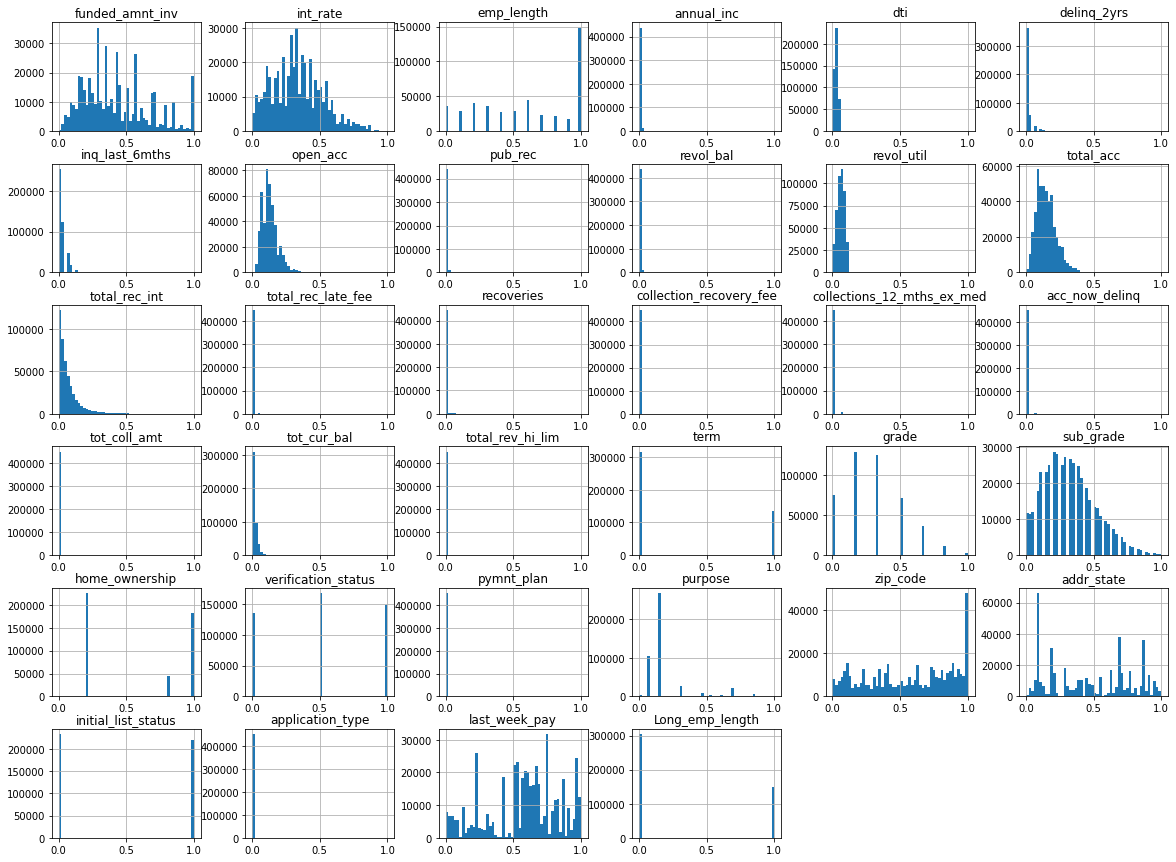

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
X_train.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
def model_training_tracking(params):

      auc_list = []
      
      lgb_clf = LGBMClassifier(**params)
      lgb_clf.fit(X_train, y_train, 
                    eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=100,
                    verbose=20)

        # Perform model evaluation 
      lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
      roc_auc = auc(fpr, tpr) # compute area under the curve
      print("=====================================")
      print("Validation AUC:{}".format(roc_auc))
      print("=====================================")   

      score_lgb_valid_prediction = lgb_clf.predict(X_valid)
      score = f1_score(y_valid, score_lgb_valid_prediction, average='weighted')# compute f1 score
      score = 100* score
      print("=====================================")
      print("Validation f1 score:{}".format(score))
      print("=====================================")  
      return roc_auc

In [ ]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
        "boosting_type": "gbdt",
        "max_depth": 10
    }
    
    score = model_training_tracking(param)
    return score

In [ ]:
'''
param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
        "boosting_type": "gbdt",
        "max_depth": 10
    }

score = model_training_tracking(param)

print(score)'''

'\nparam = {\n        "objective": "binary",\n        "metric": "auc",\n        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        "subsample": trial.suggest_float("subsample", 0.4, 1.0),\n        "random_state": 42,\n        "boosting_type": "gbdt",\n        "max_depth": 10\n    }\n\nscore = model_training_tracking(param)\n\nprint(score)'

In [ ]:
X_train

,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status,application_type,last_week_pay,Long_emp_length
86393,0.571429,0.108576,0.9,0.013647,0.019747,0.033333,0.000000,0.211111,0.000000,0.008536,0.091785,0.180124,0.052047,0.0,0.0,0.0,0.0,0.0,0.000000,0.006440,0.002710,0.0,0.000000,0.117647,1.0,0.5,0.0,0.076923,0.016949,0.38,0.0,0.0,0.655172,0.0
189603,0.571429,0.294466,1.0,0.011579,0.016594,0.000000,0.032258,0.122222,0.000000,0.003200,0.047294,0.167702,0.053930,0.0,0.0,0.0,0.0,0.0,0.001287,0.018826,0.001950,0.0,0.333333,0.294118,0.2,0.5,0.0,0.153846,0.832627,0.64,1.0,0.0,0.568966,1.0
392810,0.346429,0.580059,0.4,0.006204,0.033322,0.000000,0.000000,0.177778,0.000000,0.006539,0.099070,0.204969,0.128330,0.0,0.0,0.0,0.0,0.0,0.000000,0.018019,0.001900,0.0,0.500000,0.529412,1.0,0.0,0.0,0.153846,0.891949,0.08,0.0,0.0,0.948276,0.0
280602,0.078571,0.287283,0.5,0.005146,0.017769,0.000000,0.032258,0.088889,0.000000,0.000942,0.090440,0.192547,0.020421,0.0,0.0,0.0,0.0,0.0,0.000103,0.003636,0.000300,0.0,0.166667,0.205882,1.0,0.0,0.0,0.153846,0.500000,0.70,0.0,0.0,0.068966,0.0
527930,0.713571,0.197296,0.4,0.008478,0.027077,0.000000,0.000000,0.211111,0.000000,0.013583,0.061526,0.211180,0.049331,0.0,0.0,0.0,0.0,0.0,0.000000,0.031862,0.006360,1.0,0.166667,0.205882,0.2,0.5,0.0,0.153846,0.593220,0.96,0.0,0.0,0.534483,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108456,0.160000,0.162653,0.2,0.004572,0.001219,0.000000,0.032258,0.055556,0.000000,0.000048,0.001905,0.031056,0.015593,0.0,0.0,0.0,0.0,0.0,0.000000,0.000015,0.000740,0.0,0.166667,0.176471,1.0,0.0,0.0,0.000000,0.091102,0.62,0.0,0.0,0.620690,0.0
299764,0.137143,0.120828,0.3,0.006754,0.021501,0.000000,0.000000,0.055556,0.011628,0.001394,0.050207,0.062112,0.008576,0.0,0.0,0.0,0.0,0.0,0.000000,0.028806,0.000800,0.0,0.166667,0.147059,0.2,0.0,0.0,0.153846,0.656780,0.48,0.0,0.0,0.568966,0.0
105606,0.045714,0.029996,0.6,0.003538,0.023315,0.000000,0.000000,0.088889,0.000000,0.001004,0.017819,0.124224,0.006127,0.0,0.0,0.0,0.0,0.0,0.000430,0.017444,0.003208,0.0,0.000000,0.000000,0.8,0.0,0.0,0.307692,0.430085,0.02,0.0,0.0,0.189655,0.0
443749,0.371429,0.324039,0.8,0.009052,0.008699,0.033333,0.000000,0.100000,0.000000,0.002119,0.091001,0.086957,0.088722,0.0,0.0,0.0,0.0,0.0,0.000000,0.007124,0.000670,1.0,0.333333,0.294118,0.2,0.5,0.0,0.076923,0.726695,0.86,1.0,0.0,0.793103,0.0


In [ ]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
trial = study.best_trial
print('score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-03-30 23:35:17,000] A new study created in memory with name: no-name-9a7125c7-2290-4a71-8e6c-7f93aea7c81d


Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.823579	valid_1's auc: 0.820879
[40]	training's auc: 0.83037	valid_1's auc: 0.827944
[60]	training's auc: 0.836905	valid_1's auc: 0.83454
[80]	training's auc: 0.842178	valid_1's auc: 0.839742
[100]	training's auc: 0.844083	valid_1's auc: 0.841572
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.844083	valid_1's auc: 0.841572
Validation AUC:0.8415716686322842


[I 2021-03-30 23:35:31,511] Trial 0 finished with value: 0.8415716686322842 and parameters: {'learning_rate': 0.010745205039388417, 'colsample_bytree': 0.7398015141840775, 'subsample': 0.8509245686735094}. Best is trial 0 with value: 0.8415716686322842.


Validation f1 score:78.781149350212
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.827355	valid_1's auc: 0.824537
[40]	training's auc: 0.836104	valid_1's auc: 0.8332
[60]	training's auc: 0.844151	valid_1's auc: 0.841528
[80]	training's auc: 0.850648	valid_1's auc: 0.848077
[100]	training's auc: 0.85395	valid_1's auc: 0.851468
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.85395	valid_1's auc: 0.851468
Validation AUC:0.8514676221134959


[I 2021-03-30 23:35:45,606] Trial 1 finished with value: 0.8514676221134959 and parameters: {'learning_rate': 0.016024993696117127, 'colsample_bytree': 0.6967313085032987, 'subsample': 0.948445147492826}. Best is trial 1 with value: 0.8514676221134959.


Validation f1 score:80.00079391554952
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.841298	valid_1's auc: 0.838639
[40]	training's auc: 0.863052	valid_1's auc: 0.860284
[60]	training's auc: 0.881624	valid_1's auc: 0.879462
[80]	training's auc: 0.897525	valid_1's auc: 0.895611
[100]	training's auc: 0.906603	valid_1's auc: 0.904777
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.906603	valid_1's auc: 0.904777
Validation AUC:0.9047768454397301


[I 2021-03-30 23:35:58,634] Trial 2 finished with value: 0.9047768454397301 and parameters: {'learning_rate': 0.07698737178896879, 'colsample_bytree': 0.472406309934398, 'subsample': 0.7547321673758447}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:85.61097511301998
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.811062	valid_1's auc: 0.807018
[40]	training's auc: 0.821808	valid_1's auc: 0.819159
[60]	training's auc: 0.828377	valid_1's auc: 0.82511
[80]	training's auc: 0.827903	valid_1's auc: 0.824464
[100]	training's auc: 0.836627	valid_1's auc: 0.833055
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.836999	valid_1's auc: 0.833429
Validation AUC:0.8334289618418946


[I 2021-03-30 23:36:10,572] Trial 3 finished with value: 0.8334289618418946 and parameters: {'learning_rate': 0.013476344735261273, 'colsample_bytree': 0.2137309205095037, 'subsample': 0.5280720333275492}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:76.92812445229976
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.826173	valid_1's auc: 0.823392
[40]	training's auc: 0.831034	valid_1's auc: 0.828177
[60]	training's auc: 0.831412	valid_1's auc: 0.828478
[80]	training's auc: 0.835437	valid_1's auc: 0.832626
[100]	training's auc: 0.836227	valid_1's auc: 0.833602
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.837098	valid_1's auc: 0.834474
Validation AUC:0.8344738879377263


[I 2021-03-30 23:36:24,128] Trial 4 finished with value: 0.8344738879377263 and parameters: {'learning_rate': 0.004469270937210076, 'colsample_bytree': 0.568867532414354, 'subsample': 0.46986699853899444}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:66.15442283741693
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.821341	valid_1's auc: 0.819709
[40]	training's auc: 0.836178	valid_1's auc: 0.834276
[60]	training's auc: 0.850669	valid_1's auc: 0.848848
[80]	training's auc: 0.863319	valid_1's auc: 0.861505
[100]	training's auc: 0.873624	valid_1's auc: 0.871718
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.873624	valid_1's auc: 0.871718
Validation AUC:0.8717175978806361


[I 2021-03-30 23:36:39,651] Trial 5 finished with value: 0.8717175978806361 and parameters: {'learning_rate': 0.03148600289158794, 'colsample_bytree': 0.988751485530664, 'subsample': 0.7069371196342189}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:82.69947628785637
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.801913	valid_1's auc: 0.799812
[40]	training's auc: 0.822884	valid_1's auc: 0.820952
[60]	training's auc: 0.829665	valid_1's auc: 0.827736
[80]	training's auc: 0.83588	valid_1's auc: 0.833856
[100]	training's auc: 0.840539	valid_1's auc: 0.838596
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.840539	valid_1's auc: 0.838596
Validation AUC:0.8385958896136168


[I 2021-03-30 23:36:54,616] Trial 6 finished with value: 0.8385958896136168 and parameters: {'learning_rate': 0.015782217307806882, 'colsample_bytree': 0.9114786307632874, 'subsample': 0.5908394511244331}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:79.83922764358881
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.836439	valid_1's auc: 0.833799
[40]	training's auc: 0.85088	valid_1's auc: 0.848121
[60]	training's auc: 0.860397	valid_1's auc: 0.857456
[80]	training's auc: 0.869471	valid_1's auc: 0.866716
[100]	training's auc: 0.87932	valid_1's auc: 0.876827
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.87932	valid_1's auc: 0.876827
Validation AUC:0.8768266838729316


[I 2021-03-30 23:37:08,165] Trial 7 finished with value: 0.8768266838729316 and parameters: {'learning_rate': 0.03995797633357059, 'colsample_bytree': 0.49030816753772594, 'subsample': 0.4934256561333342}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:82.40425098476554
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.829982	valid_1's auc: 0.826259
[40]	training's auc: 0.851714	valid_1's auc: 0.848645
[60]	training's auc: 0.868466	valid_1's auc: 0.864812
[80]	training's auc: 0.875824	valid_1's auc: 0.872021
[100]	training's auc: 0.887743	valid_1's auc: 0.884133
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.887743	valid_1's auc: 0.884133
Validation AUC:0.8841330686424805


[I 2021-03-30 23:37:20,269] Trial 8 finished with value: 0.8841330686424805 and parameters: {'learning_rate': 0.09074729164964503, 'colsample_bytree': 0.2164229986932325, 'subsample': 0.882362663253182}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:83.12161139931894
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.81855	valid_1's auc: 0.815284
[40]	training's auc: 0.822873	valid_1's auc: 0.819871
[60]	training's auc: 0.823585	valid_1's auc: 0.8208
[80]	training's auc: 0.827307	valid_1's auc: 0.824493
[100]	training's auc: 0.826691	valid_1's auc: 0.824026
Did not meet early stopping. Best iteration is:
[76]	training's auc: 0.82854	valid_1's auc: 0.825786
Validation AUC:0.8257863153400826


[I 2021-03-30 23:37:34,035] Trial 9 finished with value: 0.8257863153400826 and parameters: {'learning_rate': 0.001138816807951133, 'colsample_bytree': 0.6908572884141286, 'subsample': 0.9082413648236958}. Best is trial 2 with value: 0.9047768454397301.


Validation f1 score:66.15442283741693
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.846056	valid_1's auc: 0.842897
[40]	training's auc: 0.870246	valid_1's auc: 0.867207
[60]	training's auc: 0.887149	valid_1's auc: 0.884865
[80]	training's auc: 0.89955	valid_1's auc: 0.897556
[100]	training's auc: 0.907465	valid_1's auc: 0.905416
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.907465	valid_1's auc: 0.905416
Validation AUC:0.9054158942760401


[I 2021-03-30 23:37:46,705] Trial 10 finished with value: 0.9054158942760401 and parameters: {'learning_rate': 0.08891630443589676, 'colsample_bytree': 0.38542685471986166, 'subsample': 0.7396445130347392}. Best is trial 10 with value: 0.9054158942760401.


Validation f1 score:85.74860108504947
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.846226	valid_1's auc: 0.843069
[40]	training's auc: 0.870021	valid_1's auc: 0.866903
[60]	training's auc: 0.88906	valid_1's auc: 0.886766
[80]	training's auc: 0.90067	valid_1's auc: 0.898598
[100]	training's auc: 0.907787	valid_1's auc: 0.905594
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.907787	valid_1's auc: 0.905594
Validation AUC:0.9055942888724021


[I 2021-03-30 23:37:59,351] Trial 11 finished with value: 0.9055942888724021 and parameters: {'learning_rate': 0.09166529154616795, 'colsample_bytree': 0.37360634947331106, 'subsample': 0.7513079583291615}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:85.74932882533393
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.83702	valid_1's auc: 0.832845
[40]	training's auc: 0.861008	valid_1's auc: 0.857203
[60]	training's auc: 0.885279	valid_1's auc: 0.882664
[80]	training's auc: 0.898154	valid_1's auc: 0.895936
[100]	training's auc: 0.905684	valid_1's auc: 0.90368
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.905684	valid_1's auc: 0.90368
Validation AUC:0.9036800837360801


[I 2021-03-30 23:38:11,954] Trial 12 finished with value: 0.9036800837360801 and parameters: {'learning_rate': 0.08771206929507246, 'colsample_bytree': 0.3443623222785932, 'subsample': 0.7894506379139297}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:85.42825733024239
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.83358	valid_1's auc: 0.829843
[40]	training's auc: 0.852925	valid_1's auc: 0.849542
[60]	training's auc: 0.863281	valid_1's auc: 0.860024
[80]	training's auc: 0.873666	valid_1's auc: 0.87093
[100]	training's auc: 0.879322	valid_1's auc: 0.876684
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.879322	valid_1's auc: 0.876684
Validation AUC:0.8766835348996702


[I 2021-03-30 23:38:24,415] Trial 13 finished with value: 0.8766835348996702 and parameters: {'learning_rate': 0.04337713792047626, 'colsample_bytree': 0.3271045239365022, 'subsample': 0.6247468518260523}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:81.86461569961813
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.822404	valid_1's auc: 0.819404
[40]	training's auc: 0.834395	valid_1's auc: 0.831239
[60]	training's auc: 0.834174	valid_1's auc: 0.831103
[80]	training's auc: 0.837859	valid_1's auc: 0.835078
[100]	training's auc: 0.838136	valid_1's auc: 0.83534
Did not meet early stopping. Best iteration is:
[95]	training's auc: 0.839133	valid_1's auc: 0.836349
Validation AUC:0.8363491033721918


[I 2021-03-30 23:38:37,056] Trial 14 finished with value: 0.8363491033721918 and parameters: {'learning_rate': 0.0037987710669782878, 'colsample_bytree': 0.37629132491214917, 'subsample': 0.6597208547891705}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:66.15442283741693
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.843453	valid_1's auc: 0.840394
[40]	training's auc: 0.857914	valid_1's auc: 0.85493
[60]	training's auc: 0.87143	valid_1's auc: 0.86852
[80]	training's auc: 0.886336	valid_1's auc: 0.884093
[100]	training's auc: 0.89573	valid_1's auc: 0.893706
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.89573	valid_1's auc: 0.893706
Validation AUC:0.8937059457199691


[I 2021-03-30 23:38:50,230] Trial 15 finished with value: 0.8937059457199691 and parameters: {'learning_rate': 0.05920246629724187, 'colsample_bytree': 0.4378534282177839, 'subsample': 0.8112919181168642}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:84.22646845501069
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.839003	valid_1's auc: 0.837148
[40]	training's auc: 0.840527	valid_1's auc: 0.838506
[60]	training's auc: 0.841956	valid_1's auc: 0.839517
[80]	training's auc: 0.845696	valid_1's auc: 0.842939
[100]	training's auc: 0.848288	valid_1's auc: 0.845411
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.848397	valid_1's auc: 0.845538
Validation AUC:0.8455377132391488


[I 2021-03-30 23:39:02,471] Trial 16 finished with value: 0.8455377132391488 and parameters: {'learning_rate': 0.024742948576930514, 'colsample_bytree': 0.2657798016853994, 'subsample': 0.7211615523566216}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:79.39590234266653
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.82716	valid_1's auc: 0.824388
[40]	training's auc: 0.832695	valid_1's auc: 0.829794
[60]	training's auc: 0.83348	valid_1's auc: 0.830575
[80]	training's auc: 0.836607	valid_1's auc: 0.833711
[100]	training's auc: 0.837699	valid_1's auc: 0.834983
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.838548	valid_1's auc: 0.835821
Validation AUC:0.8358208436298541


[I 2021-03-30 23:39:16,112] Trial 17 finished with value: 0.8358208436298541 and parameters: {'learning_rate': 0.005694018647119884, 'colsample_bytree': 0.5747988325538311, 'subsample': 0.990190288331153}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:75.22297244752356
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.822099	valid_1's auc: 0.818809
[40]	training's auc: 0.827734	valid_1's auc: 0.824398
[60]	training's auc: 0.828058	valid_1's auc: 0.824867
[80]	training's auc: 0.830619	valid_1's auc: 0.827475
[100]	training's auc: 0.830282	valid_1's auc: 0.827249
Did not meet early stopping. Best iteration is:
[95]	training's auc: 0.831503	valid_1's auc: 0.828505
Validation AUC:0.828505097142316


[I 2021-03-30 23:39:29,178] Trial 18 finished with value: 0.828505097142316 and parameters: {'learning_rate': 0.00123837096604696, 'colsample_bytree': 0.4128045916635552, 'subsample': 0.5873871926883114}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:66.15442283741693
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.847318	valid_1's auc: 0.845256
[40]	training's auc: 0.862848	valid_1's auc: 0.860307
[60]	training's auc: 0.874018	valid_1's auc: 0.871121
[80]	training's auc: 0.885482	valid_1's auc: 0.882409
[100]	training's auc: 0.893117	valid_1's auc: 0.88988
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893117	valid_1's auc: 0.88988
Validation AUC:0.8898796319575886


[I 2021-03-30 23:39:41,473] Trial 19 finished with value: 0.8898796319575886 and parameters: {'learning_rate': 0.09834662355741465, 'colsample_bytree': 0.28604581983209587, 'subsample': 0.6814681085528148}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:83.96903719095154
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.838285	valid_1's auc: 0.835844
[40]	training's auc: 0.854695	valid_1's auc: 0.852113
[60]	training's auc: 0.867242	valid_1's auc: 0.864385
[80]	training's auc: 0.881171	valid_1's auc: 0.878758
[100]	training's auc: 0.890617	valid_1's auc: 0.888359
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.890617	valid_1's auc: 0.888359
Validation AUC:0.8883592647923736


[I 2021-03-30 23:39:54,893] Trial 20 finished with value: 0.8883592647923736 and parameters: {'learning_rate': 0.052353377732728405, 'colsample_bytree': 0.5132792176485194, 'subsample': 0.8013429444321908}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:83.72023147403253
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.840774	valid_1's auc: 0.837892
[40]	training's auc: 0.864006	valid_1's auc: 0.861393
[60]	training's auc: 0.881391	valid_1's auc: 0.879219
[80]	training's auc: 0.895968	valid_1's auc: 0.894125
[100]	training's auc: 0.905007	valid_1's auc: 0.90326
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.905007	valid_1's auc: 0.90326
Validation AUC:0.9032596586771078


[I 2021-03-30 23:40:08,106] Trial 21 finished with value: 0.9032596586771078 and parameters: {'learning_rate': 0.07302953600266794, 'colsample_bytree': 0.4669571754558384, 'subsample': 0.748601521667872}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:85.35588016904447
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.831826	valid_1's auc: 0.828941
[40]	training's auc: 0.846075	valid_1's auc: 0.843322
[60]	training's auc: 0.852808	valid_1's auc: 0.849847
[80]	training's auc: 0.860487	valid_1's auc: 0.857629
[100]	training's auc: 0.8643	valid_1's auc: 0.861564
Did not meet early stopping. Best iteration is:
[95]	training's auc: 0.86451	valid_1's auc: 0.861781
Validation AUC:0.861781441729047


[I 2021-03-30 23:40:21,037] Trial 22 finished with value: 0.861781441729047 and parameters: {'learning_rate': 0.02590758778670699, 'colsample_bytree': 0.4067874172222371, 'subsample': 0.7489957618899084}. Best is trial 11 with value: 0.9055942888724021.


Validation f1 score:80.08535136858893
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.854685	valid_1's auc: 0.852213
[40]	training's auc: 0.880076	valid_1's auc: 0.878261
[60]	training's auc: 0.896857	valid_1's auc: 0.894981
[80]	training's auc: 0.907403	valid_1's auc: 0.905321
[100]	training's auc: 0.914479	valid_1's auc: 0.912539
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.914479	valid_1's auc: 0.912539
Validation AUC:0.9125388522161553


[I 2021-03-30 23:40:34,423] Trial 23 finished with value: 0.9125388522161553 and parameters: {'learning_rate': 0.09242586747141703, 'colsample_bytree': 0.5265421346912044, 'subsample': 0.769470076471416}. Best is trial 23 with value: 0.9125388522161553.


Validation f1 score:86.66544962591813
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.84388	valid_1's auc: 0.841641
[40]	training's auc: 0.858748	valid_1's auc: 0.85633
[60]	training's auc: 0.875517	valid_1's auc: 0.873387
[80]	training's auc: 0.885748	valid_1's auc: 0.883925
[100]	training's auc: 0.894225	valid_1's auc: 0.892694
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.894225	valid_1's auc: 0.892694
Validation AUC:0.8926941422263766


[I 2021-03-30 23:40:48,215] Trial 24 finished with value: 0.8926941422263766 and parameters: {'learning_rate': 0.05371390696200399, 'colsample_bytree': 0.6211732234994297, 'subsample': 0.8187024282806801}. Best is trial 23 with value: 0.9125388522161553.


Validation f1 score:84.49195782952499
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.854553	valid_1's auc: 0.852095
[40]	training's auc: 0.879602	valid_1's auc: 0.877777
[60]	training's auc: 0.898498	valid_1's auc: 0.896757
[80]	training's auc: 0.907887	valid_1's auc: 0.906021
[100]	training's auc: 0.915308	valid_1's auc: 0.913256
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.915308	valid_1's auc: 0.913256
Validation AUC:0.9132558352577811


[I 2021-03-30 23:41:01,445] Trial 25 finished with value: 0.9132558352577811 and parameters: {'learning_rate': 0.09291232935256831, 'colsample_bytree': 0.5408005755435489, 'subsample': 0.6391410166973541}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:86.7949925502198
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.819629	valid_1's auc: 0.816742
[40]	training's auc: 0.822928	valid_1's auc: 0.819747
[60]	training's auc: 0.825942	valid_1's auc: 0.822955
[80]	training's auc: 0.828265	valid_1's auc: 0.825312
[100]	training's auc: 0.828451	valid_1's auc: 0.825712
Did not meet early stopping. Best iteration is:
[92]	training's auc: 0.829506	valid_1's auc: 0.826679
Validation AUC:0.8266794339274177


[I 2021-03-30 23:41:15,081] Trial 26 finished with value: 0.8266794339274177 and parameters: {'learning_rate': 0.0018042453035355236, 'colsample_bytree': 0.6170782294198246, 'subsample': 0.6223284113921829}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:66.15442283741693
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.831847	valid_1's auc: 0.829942
[40]	training's auc: 0.844273	valid_1's auc: 0.842345
[60]	training's auc: 0.856083	valid_1's auc: 0.8542
[80]	training's auc: 0.868738	valid_1's auc: 0.866874
[100]	training's auc: 0.878687	valid_1's auc: 0.876965
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.878687	valid_1's auc: 0.876965
Validation AUC:0.8769651500314983


[I 2021-03-30 23:41:29,611] Trial 27 finished with value: 0.8769651500314983 and parameters: {'learning_rate': 0.035436775726339804, 'colsample_bytree': 0.797333700699953, 'subsample': 0.6593572153145418}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:83.02493123619993
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.848205	valid_1's auc: 0.845529
[40]	training's auc: 0.865951	valid_1's auc: 0.863196
[60]	training's auc: 0.879638	valid_1's auc: 0.877144
[80]	training's auc: 0.891277	valid_1's auc: 0.88915
[100]	training's auc: 0.901538	valid_1's auc: 0.899738
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.901538	valid_1's auc: 0.899738
Validation AUC:0.8997383975884262


[I 2021-03-30 23:41:43,082] Trial 28 finished with value: 0.8997383975884262 and parameters: {'learning_rate': 0.06496826678719941, 'colsample_bytree': 0.5352350997170708, 'subsample': 0.5344277971678585}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:84.98985267784582
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.825295	valid_1's auc: 0.822307
[40]	training's auc: 0.829812	valid_1's auc: 0.826857
[60]	training's auc: 0.835527	valid_1's auc: 0.832903
[80]	training's auc: 0.840275	valid_1's auc: 0.837648
[100]	training's auc: 0.841445	valid_1's auc: 0.838977
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.84197	valid_1's auc: 0.839462
Validation AUC:0.8394620812559086


[I 2021-03-30 23:41:57,002] Trial 29 finished with value: 0.8394620812559086 and parameters: {'learning_rate': 0.008332126184387577, 'colsample_bytree': 0.6472327980856843, 'subsample': 0.8468904090792024}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:78.25100624010385
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.823841	valid_1's auc: 0.821496
[40]	training's auc: 0.835877	valid_1's auc: 0.833492
[60]	training's auc: 0.844699	valid_1's auc: 0.84249
[80]	training's auc: 0.850495	valid_1's auc: 0.84833
[100]	training's auc: 0.857386	valid_1's auc: 0.855229
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.857386	valid_1's auc: 0.855229
Validation AUC:0.8552294764426815


[I 2021-03-30 23:42:11,708] Trial 30 finished with value: 0.8552294764426815 and parameters: {'learning_rate': 0.021358056003832157, 'colsample_bytree': 0.8011998666643023, 'subsample': 0.4254208303324316}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:81.03143648237985
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.837896	valid_1's auc: 0.833781
[40]	training's auc: 0.861911	valid_1's auc: 0.857882
[60]	training's auc: 0.886198	valid_1's auc: 0.883594
[80]	training's auc: 0.898864	valid_1's auc: 0.896267
[100]	training's auc: 0.906412	valid_1's auc: 0.903871
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.906412	valid_1's auc: 0.903871
Validation AUC:0.9038711921200125


[I 2021-03-30 23:42:24,472] Trial 31 finished with value: 0.9038711921200125 and parameters: {'learning_rate': 0.0893139069126103, 'colsample_bytree': 0.3530496319764106, 'subsample': 0.7634958603138317}. Best is trial 25 with value: 0.9132558352577811.


Validation f1 score:85.44431492393785
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.855679	valid_1's auc: 0.853013
[40]	training's auc: 0.880116	valid_1's auc: 0.878147
[60]	training's auc: 0.89762	valid_1's auc: 0.896113
[80]	training's auc: 0.907777	valid_1's auc: 0.906142
[100]	training's auc: 0.91545	valid_1's auc: 0.913537
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.91545	valid_1's auc: 0.913537
Validation AUC:0.9135373508662157


[I 2021-03-30 23:42:37,814] Trial 32 finished with value: 0.9135373508662157 and parameters: {'learning_rate': 0.09444931970410844, 'colsample_bytree': 0.5320100569066916, 'subsample': 0.7051959146335118}. Best is trial 32 with value: 0.9135373508662157.


Validation f1 score:86.88691402571081
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.841013	valid_1's auc: 0.838578
[40]	training's auc: 0.857395	valid_1's auc: 0.854737
[60]	training's auc: 0.868435	valid_1's auc: 0.866116
[80]	training's auc: 0.879552	valid_1's auc: 0.877577
[100]	training's auc: 0.887794	valid_1's auc: 0.885978
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.887794	valid_1's auc: 0.885978
Validation AUC:0.8859778820705293


[I 2021-03-30 23:42:51,343] Trial 33 finished with value: 0.8859778820705293 and parameters: {'learning_rate': 0.048116474589716296, 'colsample_bytree': 0.5426611387852699, 'subsample': 0.6898145543104969}. Best is trial 32 with value: 0.9135373508662157.


Validation f1 score:83.28338121002426
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.846038	valid_1's auc: 0.843689
[40]	training's auc: 0.863884	valid_1's auc: 0.861269
[60]	training's auc: 0.881308	valid_1's auc: 0.878878
[80]	training's auc: 0.893772	valid_1's auc: 0.891801
[100]	training's auc: 0.902283	valid_1's auc: 0.90045
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.902283	valid_1's auc: 0.90045
Validation AUC:0.9004495656824314


[I 2021-03-30 23:43:05,282] Trial 34 finished with value: 0.9004495656824314 and parameters: {'learning_rate': 0.0656632749391122, 'colsample_bytree': 0.658054407833153, 'subsample': 0.6253304920351695}. Best is trial 32 with value: 0.9135373508662157.


Validation f1 score:85.44967536306625
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.855244	valid_1's auc: 0.853057
[40]	training's auc: 0.883262	valid_1's auc: 0.881235
[60]	training's auc: 0.899776	valid_1's auc: 0.898115
[80]	training's auc: 0.908629	valid_1's auc: 0.906891
[100]	training's auc: 0.915203	valid_1's auc: 0.913296
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.915203	valid_1's auc: 0.913296
Validation AUC:0.9132957158895794


[I 2021-03-30 23:43:19,530] Trial 35 finished with value: 0.9132957158895794 and parameters: {'learning_rate': 0.09577754414316496, 'colsample_bytree': 0.7439038837135432, 'subsample': 0.7788837949250141}. Best is trial 32 with value: 0.9135373508662157.


Validation f1 score:87.14683317867707
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.849158	valid_1's auc: 0.84724
[40]	training's auc: 0.871153	valid_1's auc: 0.869489
[60]	training's auc: 0.888069	valid_1's auc: 0.886857
[80]	training's auc: 0.898968	valid_1's auc: 0.897686
[100]	training's auc: 0.908203	valid_1's auc: 0.906984
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.908203	valid_1's auc: 0.906984
Validation AUC:0.9069835572177695


[I 2021-03-30 23:43:33,640] Trial 36 finished with value: 0.9069835572177695 and parameters: {'learning_rate': 0.07160347291757113, 'colsample_bytree': 0.7407486235861104, 'subsample': 0.8324831069100952}. Best is trial 32 with value: 0.9135373508662157.


Validation f1 score:86.10835470808642
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.858362	valid_1's auc: 0.856249
[40]	training's auc: 0.882423	valid_1's auc: 0.880348
[60]	training's auc: 0.897381	valid_1's auc: 0.895781
[80]	training's auc: 0.908652	valid_1's auc: 0.907169
[100]	training's auc: 0.916267	valid_1's auc: 0.914789
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.916267	valid_1's auc: 0.914789
Validation AUC:0.9147894142621342


[I 2021-03-30 23:43:47,591] Trial 37 finished with value: 0.9147894142621342 and parameters: {'learning_rate': 0.09867994991398799, 'colsample_bytree': 0.7507893994082473, 'subsample': 0.865561007918863}. Best is trial 37 with value: 0.9147894142621342.


Validation f1 score:87.1996637892768
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.821954	valid_1's auc: 0.820044
[40]	training's auc: 0.838492	valid_1's auc: 0.836333
[60]	training's auc: 0.854432	valid_1's auc: 0.852165
[80]	training's auc: 0.867769	valid_1's auc: 0.865592
[100]	training's auc: 0.878554	valid_1's auc: 0.876337
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.878554	valid_1's auc: 0.876337
Validation AUC:0.8763374603346473


[I 2021-03-30 23:44:02,297] Trial 38 finished with value: 0.8763374603346473 and parameters: {'learning_rate': 0.03457222862944522, 'colsample_bytree': 0.8865158449509212, 'subsample': 0.8960179227128595}. Best is trial 37 with value: 0.9147894142621342.


Validation f1 score:82.85354219022
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.839641	valid_1's auc: 0.837073
[40]	training's auc: 0.853929	valid_1's auc: 0.85131
[60]	training's auc: 0.867412	valid_1's auc: 0.865254
[80]	training's auc: 0.878265	valid_1's auc: 0.875984
[100]	training's auc: 0.887685	valid_1's auc: 0.885785
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.887685	valid_1's auc: 0.885785
Validation AUC:0.8857852321604973


[I 2021-03-30 23:44:16,455] Trial 39 finished with value: 0.8857852321604973 and parameters: {'learning_rate': 0.04509321126024534, 'colsample_bytree': 0.7491677762283118, 'subsample': 0.9357006269167594}. Best is trial 37 with value: 0.9147894142621342.


Validation f1 score:83.8974064442366
score: 0.9147894142621342
Best hyperparameters: {'learning_rate': 0.09867994991398799, 'colsample_bytree': 0.7507893994082473, 'subsample': 0.865561007918863}


## Load best lightgbm model

Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.858362	valid_1's auc: 0.856249
[40]	training's auc: 0.882423	valid_1's auc: 0.880348
[60]	training's auc: 0.897381	valid_1's auc: 0.895781
[80]	training's auc: 0.908652	valid_1's auc: 0.907169
[100]	training's auc: 0.916267	valid_1's auc: 0.914789
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.916267	valid_1's auc: 0.914789
Validation AUC:0.9147894142621342
Validation f1 score:87.1996637892768


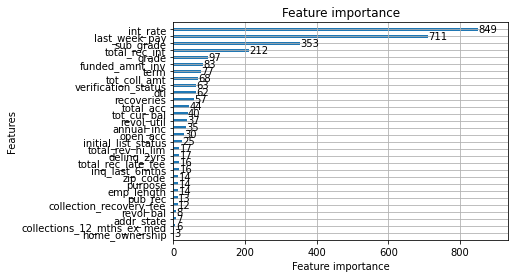

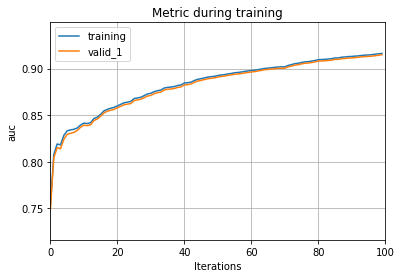

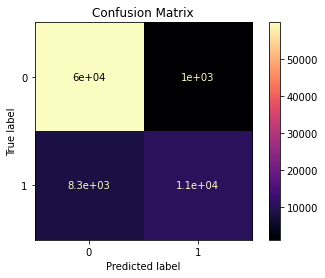

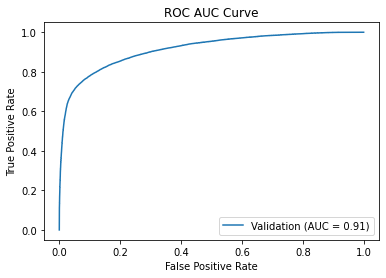

In [ ]:
    # Define model parameter
params = {
    "objective": "binary",
    "learning_rate": 0.09867994991398799,
    "metric": "auc",
    "colsample_bytree": 0.7507893994082473,
    "subsample": 0.865561007918863,
    "boosting_type": "gbdt",
    "seed": 42,
    "max_depth": 10
}

# Perform model training
lgb_clf = LGBMClassifier(**params)
lgb_clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_valid, y_valid)], 
        early_stopping_rounds=50,
        verbose=20)

# Log model artifacts
#   mlflow.sklearn.log_model(lgb_clf, "model")

# Perform model evaluation 
lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("=====================================")
print("Validation AUC:{}".format(roc_auc))
print("=====================================")   

score_lgb_valid_prediction = lgb_clf.predict(X_valid)
score = f1_score(y_valid, score_lgb_valid_prediction, average='weighted')# compute f1 score
score = 100* score
print("=====================================")
print("Validation f1 score:{}".format(score))
print("=====================================") 


# Plot and save feature importance details
ax = plot_importance(lgb_clf, height=0.4)
filename = '/content/images/lgb_validation_feature_importance.png'
plt.savefig(filename)


ax = plot_metric(lgb_clf.evals_result_)
filename = '/content/images/lgb_validation_metrics_comparision.png'
plt.savefig(filename)


# Plot and save metrics details    
plot_confusion_matrix(lgb_clf, X_valid, y_valid, 
                  display_labels=['0', '1'],
                  cmap='magma')
plt.title('Confusion Matrix')
filename = '/content/images/lgb_validation_confusion_matrix.png'
plt.savefig(filename)


# Plot and save AUC details  
plot_roc_curve(lgb_clf, X_valid, y_valid, name='Validation')
plt.title('ROC AUC Curve')
filename = '/content/images/lgb_validation_roc_curve.png'
plt.savefig(filename)


In [ ]:
test_data.head()

,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status,application_type,last_week_pay,Long_emp_length
0,0.400000,0.461343,0.4,0.008305,0.042601,0.033333,0.032258,0.177778,0.000000,0.011611,0.073182,0.322981,0.161764,0.0,0.0,0.0,0.0,0.0,0.0,0.010654,0.00457,1.0,0.333333,0.411765,1.0,0.5,0.0,0.076923,0.525424,0.70,0.0,0.0,0.034483,0.0
1,0.457143,0.176172,0.5,0.011924,0.046378,0.000000,0.000000,0.088889,0.000000,0.001620,0.021742,0.385093,0.061765,0.0,0.0,0.0,0.0,0.0,0.0,0.055623,0.00214,1.0,0.166667,0.176471,0.2,0.5,0.0,0.461538,0.302966,0.54,1.0,0.0,0.724138,0.0
2,0.315714,0.434728,1.0,0.007019,0.032311,0.033333,0.000000,0.122222,0.011628,0.004696,0.082932,0.118012,0.086600,0.0,0.0,0.0,0.0,0.0,0.0,0.013217,0.00163,1.0,0.500000,0.441176,1.0,0.0,0.0,0.153846,0.680085,0.32,1.0,0.0,0.793103,1.0
3,0.991429,0.311365,1.0,0.017093,0.025680,0.000000,0.000000,0.233333,0.000000,0.012670,0.050431,0.155280,0.072558,0.0,0.0,0.0,0.0,0.0,0.0,0.035877,0.00724,1.0,0.333333,0.323529,0.8,0.5,0.0,0.153846,1.000000,0.08,0.0,0.0,0.500000,1.0
4,0.185714,0.066329,0.5,0.005835,0.030021,0.000000,0.000000,0.177778,0.000000,0.001998,0.021517,0.217391,0.007114,0.0,0.0,0.0,0.0,0.0,0.0,0.029284,0.00267,0.0,0.000000,0.058824,0.2,0.0,0.0,0.461538,0.694915,0.36,1.0,0.0,0.500000,0.0


In [ ]:
# Make prediction aganist Validation data
lgb_best_val_prediction = lgb_clf.predict(test_data)
#print(lgb_best_val_prediction)
# dictionary of lists  
dict = {'member_id': ID, 'loan_status': lgb_best_val_prediction}  
    
df = pd.DataFrame(dict) 
df.loan_status.value_counts()

0    303561
1     51390
Name: loan_status, dtype: int64

In [ ]:
df

,member_id,loan_status
0,11937648,0
1,38983318,0
2,27999917,0
3,61514932,0
4,59622821,0
...,...,...
354946,19145105,0
354947,46304777,0
354948,903745,1
354949,53032475,0


In [ ]:
df.to_csv('/content/drive/MyDrive/Datasets/ML_Artivatic_dataset/my_submission.csv', index=False) 